<a href="https://colab.research.google.com/github/laurence-lin/Kaggle_competition/blob/master/Ashrae_predict_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math

import sklearn
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import os

import gc
from google.colab import files
# load data from Cloud Storage
from google.colab import auth
auth.authenticate_user()

# Configure GCP project and use gsutil to copy the file from storage

!gcloud config set project 'blind-detection'
!gsutil -m cp -r gs://ashare_dataset/*.csv  sample_data/



Updated property [core/project].
Copying gs://ashare_dataset/building_metadata.csv...
Copying gs://ashare_dataset/sample_submission.csv...
Copying gs://ashare_dataset/test.csv...
Copying gs://ashare_dataset/weather_train.csv...
Copying gs://ashare_dataset/train.csv...
Copying gs://ashare_dataset/weather_test.csv...
- [6/6 files][  2.4 GiB/  2.4 GiB] 100% Done  19.7 MiB/s ETA 00:00:00           
Operation completed over 6 objects/2.4 GiB.                                      


In [2]:
# Reduce memory function

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16


from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


# Load all datasets and reduce memory
print(os.listdir('sample_data/'))
data_path = 'sample_data/'
train = pd.read_csv(os.path.join(data_path, 'train.csv'), parse_dates = ['timestamp'])
test = pd.read_csv(os.path.join(data_path, 'test.csv'), parse_dates = ['timestamp'])
building = pd.read_csv(os.path.join(data_path, 'building_metadata.csv'))
weather_test = pd.read_csv(os.path.join(data_path, 'weather_test.csv'), parse_dates = ['timestamp'])
#submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
weather_train = pd.read_csv(os.path.join(data_path, 'weather_train.csv'), parse_dates = ['timestamp'])

train = reduce_mem_usage(train, use_float16 = True)
building = reduce_mem_usage(building, use_float16 = True)
weather_train = reduce_mem_usage(weather_train, use_float16 = True)
test = reduce_mem_usage(test)
weather_test = reduce_mem_usage(weather_test)


['anscombe.json', 'README.md', 'weather_train.csv', 'train.csv', 'sample_submission.csv', 'building_metadata.csv', 'test.csv', 'weather_test.csv', 'california_housing_test.csv', 'mnist_train_small.csv', 'california_housing_train.csv', 'mnist_test.csv']
Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 289.19 MB
Decreased by 53.1%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%
Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 3.07 MB
Decreased by 68.1%
Memory usage of dataframe is 1272.51 MB
Memory usage after optimization is: 596.49 MB
Decreased by 53.1%
Memory usage of dataframe is 19.04 MB
Memory usage after optimization is: 9.78 MB
Decreased by 48.6%


1. Load dataset 
2. Do EDA to analyze data structure 
3. Do feature engineering 
4. Apply model training 
5. Make test data prediction

In [3]:
# EDA: Data Analysis

# Training data: 
# train: data for each building meter readings, at each timestamp for each building
# building: data for each building meta data, at each location
# weather_train: weather at each location, at each location

# Test data: test, building, weather_test

# Prediction target: meter_reading 
print('Train file information: ')
print(train.info())


Train file information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        datetime64[ns]
meter_reading    float32
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB
None


In [4]:
print('Building meta data structure: ')
print(building.info())

Building meta data structure: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int8
building_id    1449 non-null int16
primary_use    1449 non-null category
square_feet    1449 non-null int32
year_built     675 non-null float16
floor_count    355 non-null float16
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.9 KB
None


In [5]:
print('Training weather data structure: ')
print(weather_train.info())

Training weather data structure: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null datetime64[ns]
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: datetime64[ns](1), float16(7), int8(1)
memory usage: 3.1 MB
None


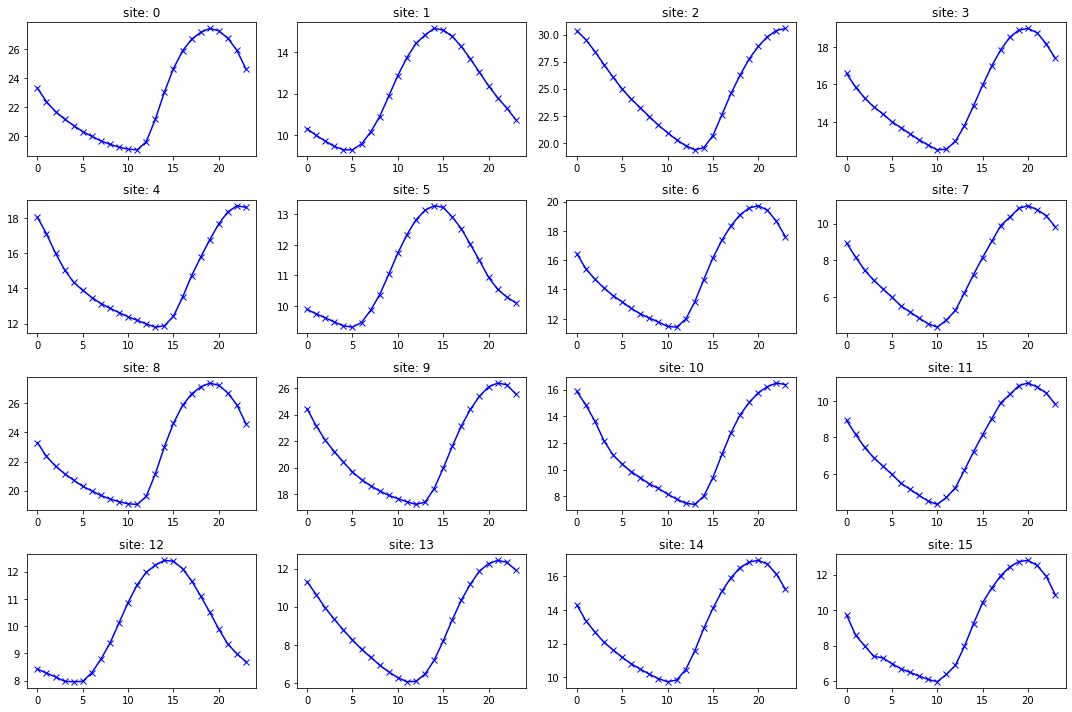

In [6]:
# First analyze the timestamp data

temp_skeleton = pd.concat([weather_train, weather_test], ignore_index = True)
weather_key = ['site_id', 'timestamp']
# Drop samples with same site and same timestamp
temp_skeleton = temp_skeleton[weather_key + ['air_temperature']].drop_duplicates( \
                              subset = weather_key).sort_values(by = weather_key)

data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour
count = 1
plt.figure(figsize=(15, 10))
for site_id, data_by_site in data_to_plot.groupby('site_id'):
    by_site_by_hour = data_by_site.groupby('hour').mean() # hourly mean value for each site(include air_temperature)
    ax = plt.subplot(4, 4, count) # plot in each subplot
    plt.plot(by_site_by_hour.index,by_site_by_hour['air_temperature'],'xb-')
    ax.set_title('site: '+str(site_id))
    count += 1
plt.tight_layout()
plt.show()
del data_to_plot

As I can see, the peak temperature is different in each site.  
However, the peak temperature happens in about 20 PM at each site in even, which is abnormal. It seems the timestamp data is not aligned, it should be aligned that peak temperature happens in noon. 
Since energy consumption is related to timestamp, we could do feature engineering by align the timestamp data to make prediction more precisely.  

By experiment, alignment does improve the prediction accuracy. 
 
  
Here, we assume the peak temperature time should happend in 14:00 each day.  
We calculatet the time difference between the peak temperature timing and 14:00 at each day, and use the difference to do time alignment.

In [7]:
# Time alignment

# Ranking of temperature in each date, at each site
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton['timestamp'].dt.date]) \
                        ['air_temperature'].rank(method = 'average')

# Create a dataframe that consisted of: site_id * hourly mean rank of temperature for 24 hours
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level = 1)

# Subtract max temperature hourly rank by 14, get time alignment gap: time gap btw 14:00 and peak temp. timing
site_offset = pd.Series(df_2d.values.argmax(axis = 1) - 14)
site_offset.index.name = 'site_id'

def time_align(df):
  # create time offset column
  df['offset'] = df.site_id.map(site_offset)
  df['timestamp_aligned'] = df.timestamp - pd.to_timedelta(df.offset, unit = 'hour')
  df['timestamp'] = df['timestamp_aligned']
  del df['timestamp_aligned']
  return df

gc.collect()

105

Since the train.csv timestamp is more aligned(Showed by plot), we don't to time alignment on train.csv data.

In [0]:
# Now, we can align weather_train, weather_test data
weather_train = time_align(weather_train)
weather_test = time_align(weather_test)

del df_2d, temp_skeleton, site_offset

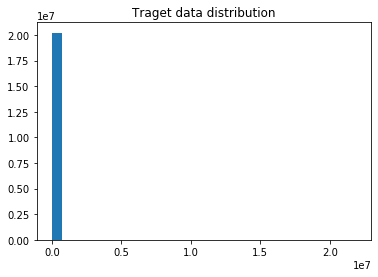

In [9]:
plt.figure()
plt.hist(train['meter_reading'], bins = 30)
plt.title('Traget data distribution')

plt.show()

Target distribution is biased, we could do log transformation in feature engineering later.

In [10]:
# Observe NaN in weather data
print('Missing values in weather_train data: \n')
print(weather_train.isnull().sum()[weather_train.isnull().sum() > 0].sort_values(ascending = False))

# Building data: 
print('Missing values in building meta data: \n')
print(building.isnull().sum()[building.isnull().sum() > 0].sort_values(ascending = False))

# Train data:
print('Missing values in train data: \n')
print(train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending = False))

Missing values in weather_train data: 

cloud_coverage        69173
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dew_temperature         113
air_temperature          55
dtype: int64
Missing values in building meta data: 

floor_count    1094
year_built      774
dtype: int64
Missing values in train data: 

Series([], dtype: int64)


In [11]:
# Do interpolation for weather data first, for too much missing values. There may still be some missing values after this.
# Interpolate by each site across the timestamp
weather_train = weather_train.groupby('site_id').apply(lambda x_site: x_site.interpolate(limit_direction = 'both'))
weather_test = weather_test.groupby('site_id').apply(lambda x_site: x_site.interpolate(limit_direction = 'both'))

print('Missing values in weather train data after interpolation: \n')
print(weather_train.isnull().sum().sort_values(ascending = False))

Missing values in weather train data after interpolation: 

precip_depth_1_hr     26273
cloud_coverage        17228
sea_level_pressure     8755
offset                    0
wind_speed                0
wind_direction            0
dew_temperature           0
air_temperature           0
timestamp                 0
site_id                   0
dtype: int64


I can see that although some NaN values is filled in weather_data, interpolation couldn't fill all of the missing values.  
We will continue this in FE.

In [0]:
# Combine data and meta datas for advanced analysis
train = train.merge(building, on = 'building_id', how = 'left')
train = train.merge(weather_train, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(building, on = 'building_id', how = 'left')
test = test.merge(weather_test, on = ['site_id', 'timestamp'], how = 'left')

del building, weather_train, weather_test



In [13]:
# After the timestamp alignment, new columns 'offset' may generate whole row that is NaN. Drop these rows
# Which means whole row with all NaN values
weather_col = ['air_temperature', 'dew_temperature', 'wind_speed', \
               'wind_direction', 'offset', 'sea_level_pressure',
               'precip_depth_1_hr', 'cloud_coverage']
train = train.dropna(subset = weather_col, how = 'all')
print(train.shape)


(20112649, 17)


In [14]:
print(train.groupby('primary_use').size().reset_index(name = 'count'))

                      primary_use    count
0                       Education  8119528
1   Entertainment/public assembly  2253421
2          Food sales and service   113952
3                      Healthcare   397740
4             Lodging/residential  2129647
5        Manufacturing/industrial   124389
6                          Office  4376486
7                           Other   242001
8                         Parking   213612
9                 Public services  1657786
10              Religious worship    31757
11                         Retail   112505
12                       Services    96421
13             Technology/science    76673
14                        Utility    54979
15              Warehouse/storage   111752


We can see there is some NaN values generated after time alignment and merge dataframe.

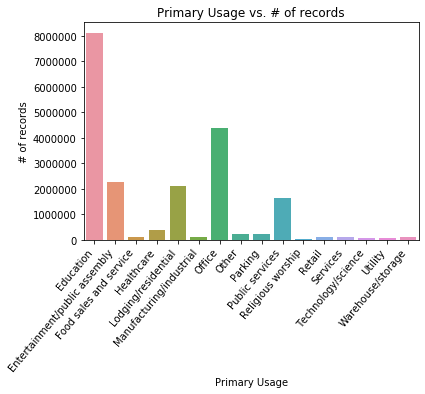

In [15]:
# Show distribution for categorical feature
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Show distribution for categorical data: primary usage
primary_count_df = train.groupby('primary_use').size().reset_index(name = 'count')
ax = sns.barplot(primary_count_df['primary_use'], primary_count_df['count'])
ax.set(xlabel= 'Primary Usage', ylabel = '# of records', title = 'Primary Usage vs. # of records')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 50, ha = 'right')

plt.show()

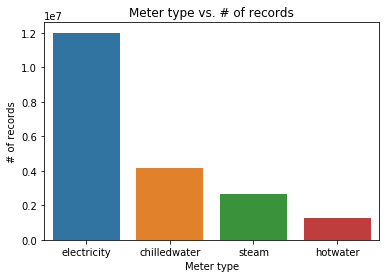

38293

In [16]:
# Distribution of meter type
meter_dict = {0:'electricity', 1:'chilledwater', 2:'steam', 3:'hotwater'}

ax = sns.barplot(train['meter'].value_counts().index.map(meter_dict), train['meter'].value_counts())
ax.set(xlabel = 'Meter type', ylabel = '# of records', title = 'Meter type vs. # of records')
plt.show()

gc.collect()

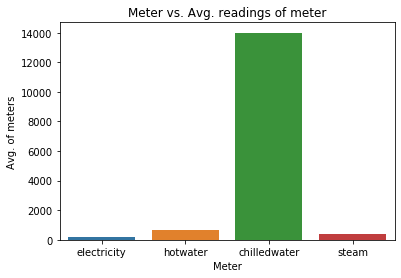

In [17]:
# Show the average readings for each meter
meters = pd.Series(train['meter'].unique()).map(meter_dict)
ax = sns.barplot(meters, train.groupby('meter')['meter_reading'].mean())
ax.set(xlabel = 'Meter', ylabel = 'Avg. of meters', title = 'Meter vs. Avg. readings of meter')

plt.show()

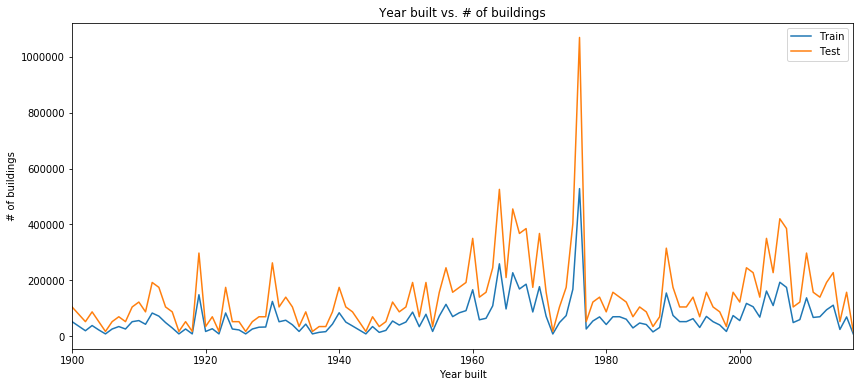

In [18]:
# Plot observations of building built in each year
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
ax.set(xlabel = 'Year built', ylabel = '# of buildings', title = 'Year built vs. # of buildings')
train['year_built'].value_counts(dropna = False).sort_index().plot(ax = ax)
test['year_built'].value_counts(dropna = False).sort_index().plot(ax = ax)
ax.legend(['Train', 'Test'])

In [19]:
print(train['square_feet'])

0             7432
1             2720
2             5376
3            23685
4           116607
             ...  
20215251    131212
20215252     12152
20215253     55800
20215254    125701
20215255    112956
Name: square_feet, Length: 20112649, dtype: int32


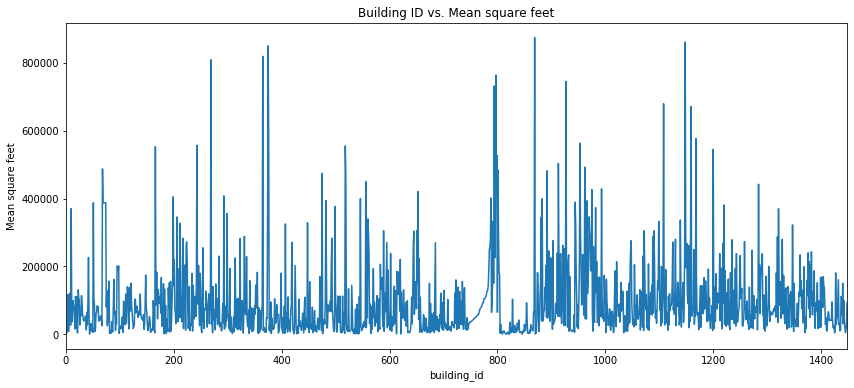

In [20]:
# Observe mean square feet for each building
fig, ax = plt.subplots(1, 1, figsize = (14, 6))
ax.set(xlabel = 'Building ID', ylabel = 'Mean square feet', title = 'Building ID vs. Mean square feet')
train.groupby('building_id')['square_feet'].mean().plot(ax = ax)


As to training data, I've about 1448 buildings to predict. 
Time scan over 3 years, each day as time step. 

In [21]:
print(train.isnull().sum().sort_values(ascending = False))
# Missing value features are all float

gc.collect()

floor_count           16618674
year_built            12105206
precip_depth_1_hr      1646098
sea_level_pressure      779195
cloud_coverage          476553
primary_use                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
offset                       0
square_feet                  0
wind_speed                   0
air_temperature              0
dew_temperature              0
wind_direction               0
building_id                  0
dtype: int64


5376

In [0]:
# Fill NaNs
from time import time


null_col = 100 - train.count()/len(train)*100
null_col = train.loc[:, null_col > 0] # dataframe from train that contain null columns

def mean_without_overflow_fast(col):
    # Compute mean value of each column which contains missing value
    col /= len(col)
    return col.mean() * len(col)

null_col_mean = null_col.apply(mean_without_overflow_fast)

for col in null_col.keys():
  # Fill mean with integer for year_built and floor_count
   if col == 'year_built' or col =='floor_count':
     train[col].fillna(math.floor(null_col_mean[col]), inplace = True)
     test[col].fillna(math.floor(null_col_mean[col]), inplace = True)
   else:
     train[col].fillna(null_col_mean[col], inplace = True)
     test[col].fillna(null_col_mean[col], inplace = True)



In [0]:
# Create new feature: feature generation

def time_transform(df):
  df['hour'] = df['timestamp'].dt.hour
  df['year'] = df['timestamp'].dt.year
  df['month'] = df.timestamp.dt.month
  df['day'] = df.timestamp.dt.day
  df['dayofweek'] = df.timestamp.dt.dayofweek
  
  return df

train = time_transform(train)
test = time_transform(test)


In [24]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


date_range = pd.date_range(start = train['timestamp'].min(), end = test['timestamp'].max())
us_holidays = calendar().holidays(start = date_range.min(), end = date_range.max())

d = pd.to_datetime(pd.Series('2018-05-01 00:00:00'))
print(type(d))
print(d.isin(us_holidays))

<class 'pandas.core.series.Series'>
0    False
dtype: bool


In [25]:
# Create is_holiday feature by US_Holiday calendar
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Add is_holiday = 1: The date that within USA_holiday, and the dates that is weekend

date_range = pd.date_range(start = train['timestamp'].min(), end = test['timestamp'].max())
us_holidays = calendar().holidays(start = date_range.min(), end = date_range.max()) # USA holidays within data date_range
# Only datetime64 could apply isin() function, which is convenient
train['is_holiday'] = (train['timestamp'].dt.date).astype('datetime64').isin(us_holidays).astype(np.int8)
test['is_holiday'] = (test['timestamp'].dt.date).astype('datetime64').isin(us_holidays).astype(np.int8)

train.loc[(train['timestamp'].dt.dayofweek == 5) | (train['timestamp'].dt.dayofweek == 6), 'is_holiday'] = 1
test.loc[(test['timestamp'].dt.dayofweek == 5) | (test['timestamp'].dt.dayofweek == 6), 'is_holiday'] = 1


gc.collect()


45

In [26]:
print('Some features that distribution may be biased and could do log transformation: ')
print('square_feet, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed')

Some features that distribution may be biased and could do log transformation: 
square_feet, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_direction, wind_speed


In [32]:
# Encode cyclic features
print(train.columns)
def encode_cyclic_feature(df, col, max_val):
  '''
  Encode cyclic feature with sin cosine transform
  df: dataframe contains cyclic feature
  col: cylcic features to transform
  max_val: max value for that cyclic column
  '''
  df[col + '_sin'] = np.sin(2*np.pi*(df[col]/max_val))
  del df[col]
  return df

print('Cyclic features: hour, day, month, dayofweek')

train = encode_cyclic_feature(train, 'dayofweek', 7)
train = encode_cyclic_feature(train, 'hour', 24)
train = encode_cyclic_feature(train, 'day', 31)
train = encode_cyclic_feature(train, 'month', 31)

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'offset', 'hour', 'year', 'month', 'date', 'dayofweek',
       'is_holiday', 'day'],
      dtype='object')
Cyclic features: hour, day, month, dayofweek


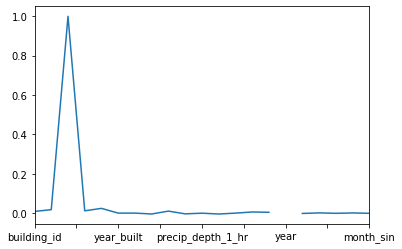

In [36]:
# Data cleaning: drop useless features and samples
train.corr()['meter_reading'].plot()

drop_features = ['wind_speed', 'sea_level_pressure']

gc.collect()

In [0]:
# Feature engineering

def build_feature(df, building, weather, is_train = False):
  '''
  df: train data or test dataframe
  '''

  # 1. Log transformation for training target
  if is_train:
    df['meter_reading'] = np.log1p(df['meter_reading'])

  # 2. Fill NaNs
  

  # 3. Categorical encoding

  # 4. Data cleaning: NaN rows, Outliers, ...etc




  return df